In [1]:
import numpy as np
import matplotlib.pyplot as plt
import copy

from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, confusion_matrix, ConfusionMatrixDisplay
from sklearn.neighbors import NearestNeighbors
from sklearn.metrics import pairwise_distances
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

import os, joblib
from joblib import Parallel, delayed
print("number of cores: ", os.cpu_count())

number of cores:  56


In [2]:
def random_unit_vector(n):
    vec = np.random.randn(n)  # Draw from standard normal
    vec /= np.linalg.norm(vec)  # Normalize to unit length
    return vec

class sim_cell:  
    new_lineage_label = 1
    def __init__(self, parent_state, differentiation_vec, lineage_label, distance_from_source):
        self.alive = True
        self.differentiation_vec = differentiation_vec
        self.lineage_label = lineage_label
        self.distance_from_source = distance_from_source

        parent_state = parent_state.copy()
        for i in range(len(parent_state)):
            parent_state[i] += np.random.normal(0, sim_cell.measure_error_var)
        self.state_vec = parent_state
        
    def proliferate(self):
        if self.differentiation_vec is not None and np.random.binomial(1, sim_cell.mutation_prob) == 1:
            sim_cell.new_lineage_label += 1
            step = np.array([np.random.normal(axis_scalar * sim_cell.ss_mean, sim_cell.ss_var) for axis_scalar in self.differentiation_vec]) \
                                                                    + random_unit_vector(len(self.differentiation_vec)) * self.stochastic_step_size
            return sim_cell(self.state_vec + step, self.differentiation_vec, sim_cell.new_lineage_label, self.distance_from_source + 1)
        else:
            return sim_cell(self.state_vec, self.differentiation_vec,  self.lineage_label, self.distance_from_source)
    
    def cell_cycle(self):
        if self.alive:
            self.alive = np.random.binomial(1, sim_cell.death_rate) == 0
            if self.differentiation_vec is None:
                if np.random.binomial(1, sim_cell.commit_diff_prob) == 1:
                    self.differentiation_vec = sim_cell.differentiation_directions[np.random.choice(range(len(sim_cell.differentiation_directions)))]
            if np.random.binomial(1, sim_cell.birth_rate) == 1:
                return self.proliferate()
            else:
                return None

In [3]:
def simulate_source_model(args):
    n_dims = args['n_dims']
    sim_cell.birth_rate = args['birth_rate']
    sim_cell.death_rate = args['death_rate']
    sim_cell.mutation_prob = args['mutation_prob']
    sim_cell.ss_mean = args['ss_mean']
    sim_cell.ss_var = args['ss_var']
    sim_cell.stochastic_step_size = args['stochastic_step_size']
    sim_cell.measure_error_var = args['measure_error_var']
    sim_cell.differentiation_directions = [random_unit_vector(n_dims) for _ in range(args['n_diff_directions'])]
    sim_cell.commit_diff_prob = args['commit_diff_prob']
    immigration_rate=args['immigration_rate']
    max_population=args['max_population']
    max_steps=args['max_steps']

    step_counter = 0
    population = [sim_cell(np.zeros(n_dims), None, 1, 0)]
    while len(population) < max_population:
        # print("Population size = ", len(population), "Step = ", step_counter)
        step_counter += 1
        if step_counter > max_steps:
            return population
        if len(population) == 0: # reached extinction: reset with population of 1
            population = [sim_cell(np.zeros(n_dims), None, 1, 0)]
        new_cells = [sim_cell(np.zeros(n_dims), None, 1, 0) for _ in range(int(immigration_rate))]
        
        dead_cell_index = []
        for i in range(len(population)):
            new_cell = population[i].cell_cycle()
            if new_cell is not None:
                new_cells.append(new_cell)
            if not population[i].alive:
                dead_cell_index.append(i)
        for i in reversed(dead_cell_index):
            population.pop(i)
        population += new_cells
    print("Simulation complete. steps = ", step_counter, "Population size = ", len(population))
    return list(np.random.choice(population, size = max_population, replace = False))


In [4]:
def generate_sim_params():
    args_template = {
        "n_dims": 100,
        "n_diff_directions": 1,
        "birth_rate": None,
        "death_rate": None,
        "mutation_prob": None,
        "immigration_rate": None, 
        "commit_diff_prob": 1,
        "ss_mean": 40,
        "ss_var": 8,
        "stochastic_step_size": 8,
        "measure_error_var": 0.5,
        "max_population": 25000, 
        "max_steps": 200,
    }
    arg_list = []
    labels = []
    # 's>0, r>0, γ=0, low p'
    for birth_rate in np.arange(0.1, 0.9, 0.16):
        for mutation_prob in np.arange(0.02, 0.32, 0.03):
            args = copy.deepcopy(args_template)
            args['birth_rate'] = birth_rate
            args['death_rate'] = birth_rate * (1 - mutation_prob) * np.random.uniform(0.1, 0.5)
            args['mutation_prob'] = mutation_prob
            args['immigration_rate'] = 0
            arg_list.append(args)
            labels.append("s>0, r>0, γ=0, low p")
            # sanity check
            s = (1 - args['mutation_prob']) * args['birth_rate'] - args['death_rate']
            r = args['birth_rate'] - args['death_rate']
            if not (s > 0 and r > 0 and args['immigration_rate'] == 0):
                print(f"Warning: s>0, r>0, γ=0, low p: {args}")
    # 's>0, r>0, γ=0, high p'
    for birth_rate in np.arange(0.1, 0.9, 0.16):
        for mutation_prob in np.arange(0.65, 0.95, 0.03):
            args = copy.deepcopy(args_template)
            args['birth_rate'] = birth_rate
            args['death_rate'] = birth_rate * (1 - mutation_prob) * np.random.uniform(0.1, 0.5)
            args['mutation_prob'] = mutation_prob
            args['immigration_rate'] = 0
            arg_list.append(args)
            labels.append("s>0, r>0, γ=0, high p")
            # sanity check
            s = (1 - args['mutation_prob']) * args['birth_rate'] - args['death_rate']
            r = args['birth_rate'] - args['death_rate']
            if not (s > 0 and r > 0):
                print(f"Warning: s>0, r>0, γ=0, high p: {args}")
    # 's<0, r<0, γ>0, low p'
    for mutation_prob in np.arange(0.05, 0.35, 0.06):
        for immigration_rate in np.arange(600, 1600, 100):
            args = copy.deepcopy(args_template)
            args['birth_rate'] = 0.78
            args['death_rate'] = 0.8
            args['mutation_prob'] = mutation_prob
            args['immigration_rate'] = immigration_rate
            arg_list.append(args)
            labels.append("s<0, r<0, γ>0, low p")
            # sanity check
            s = (1 - args['mutation_prob']) * args['birth_rate'] - args['death_rate']
            r = args['birth_rate'] - args['death_rate']
            if not (s < 0 and r < 0 and args['immigration_rate'] > 0):
                print(f"Warning: s<0, r<0, γ>0, low p: {args}")
    # 's<0, r<0, γ>0, high p'
    for mutation_prob in np.arange(0.65, 0.95, 0.06):
        for immigration_rate in np.arange(600, 1600, 100):
            args = copy.deepcopy(args_template)
            args['birth_rate'] = 0.78
            args['death_rate'] = 0.8
            args['mutation_prob'] = mutation_prob
            args['immigration_rate'] = immigration_rate
            arg_list.append(args)
            labels.append("s<0, r<0, γ>0, high p")
            # sanity check
            s = (1 - args['mutation_prob']) * args['birth_rate'] - args['death_rate']
            r = args['birth_rate'] - args['death_rate']
            if not (s < 0 and r < 0 and args['immigration_rate'] > 0):
                print(f"Warning: s<0, r<0, γ>0, high p: {args}")
    # 's<0, r>0, γ=0, high p'
    for birth_rate in np.arange(0.5, 1, 0.1):
        for mutation_prob in np.arange(0.65, 0.95, 0.025):
            # for immigration_rate in np.arange(100, 500, 100):
                args = copy.deepcopy(args_template)
                args['birth_rate'] = birth_rate
                args['death_rate'] = np.random.uniform(birth_rate * (1 - mutation_prob), birth_rate)
                args['mutation_prob'] = mutation_prob
                args['immigration_rate'] = 0
                arg_list.append(args)
                labels.append("s<0, r>0, γ=0, high p")
                # sanity check
                s = (1 - args['mutation_prob']) * args['birth_rate'] - args['death_rate']
                # args['immigration_rate'] = np.random.uniform(args['max_population'] * (args['birth_rate'] - args['death_rate']) * 0.01, args['max_population'] * (args['birth_rate'] - args['death_rate']) * 0.05)
                r = args['birth_rate'] - args['death_rate']
                if not (s < 0 and r > 0):
                    print(f"Warning: s<0, r>0, γ=0, high p: {args}")
    # 's<0, r>0, γ=0, low p'
    for birth_rate in np.arange(0.5, 1, 0.1):
        for mutation_prob in np.arange(0.05, 0.35, 0.015):
            # for immigration_rate in np.arange(100, 500, 100):
                args = copy.deepcopy(args_template)
                args['birth_rate'] = birth_rate
                args['death_rate'] = np.random.uniform(birth_rate * (1 - mutation_prob), birth_rate)
                args['mutation_prob'] = mutation_prob
                args['immigration_rate'] = 0
                arg_list.append(args)
                labels.append("s<0, r>0, γ=0, low p")
                # sanity check
                s = (1 - args['mutation_prob']) * args['birth_rate'] - args['death_rate']
                # args['immigration_rate'] = np.random.uniform(args['max_population'] * (args['birth_rate'] - args['death_rate']) * 0.01, args['max_population'] * (args['birth_rate'] - args['death_rate']) * 0.05)
                r = args['birth_rate'] - args['death_rate']
                if not (s < 0 and r > 0):
                    print(f"Warning: s<0, r>0, γ=0, low p: {args}")
    return arg_list, labels


In [5]:
all_params, labels = generate_sim_params()

import random
all_params, labels = map(list, zip(*random.sample(list(zip(all_params, labels)), k=int(len(all_params) * 0.5))))
print(len(all_params), len(labels))

populations = Parallel(n_jobs=os.cpu_count()-1)(
    delayed(simulate_source_model)(params) for params in all_params
)

180 180


Simulation complete. steps =  145 Population size =  25218
Simulation complete. steps =  32 Population size =  25342
Simulation complete. steps =  54 Population size =  29464
Simulation complete. steps =  79 Population size =  27740
Simulation complete. steps =  125 Population size =  26109
Simulation complete. steps =  27 Population size =  25585
Simulation complete. steps =  21 Population size =  31631
Simulation complete. steps =  50 Population size =  25570
Simulation complete. steps =  43 Population size =  30323
Simulation complete. steps =  129 Population size =  27017
Simulation complete. steps =  34 Population size =  32972
Simulation complete. steps =  32 Population size =  30199
Simulation complete. steps =  19 Population size =  32537
Simulation complete. steps =  32 Population size =  34361
Simulation complete. steps =  41 Population size =  29053
Simulation complete. steps =  111 Population size =  26260
Simulation complete. steps =  33 Population size =  28362
Simulation

In [6]:
drop_indices = []
for i in range(len(all_params)):
    if len(populations[i]) < all_params[0]['max_population'] * 0.6:
        drop_indices.append(i)
for i in reversed(drop_indices):
    populations.pop(i)
    all_params.pop(i)
    print("dropped", labels[i])
    labels.pop(i)
print("dropped", len(drop_indices), "populations")

dropped s<0, r>0, γ=0, low p
dropped s<0, r>0, γ=0, low p
dropped s<0, r>0, γ=0, high p
dropped s<0, r>0, γ=0, low p
dropped s<0, r>0, γ=0, low p
dropped s<0, r>0, γ=0, low p
dropped s<0, r>0, γ=0, low p
dropped s<0, r>0, γ=0, low p
dropped s<0, r>0, γ=0, high p
dropped s<0, r>0, γ=0, low p
dropped s<0, r>0, γ=0, low p
dropped s<0, r>0, γ=0, low p
dropped s<0, r>0, γ=0, low p
dropped s<0, r>0, γ=0, low p
dropped s<0, r>0, γ=0, low p
dropped s<0, r>0, γ=0, low p
dropped s<0, r>0, γ=0, low p
dropped s<0, r>0, γ=0, low p
dropped s<0, r>0, γ=0, low p
dropped s<0, r>0, γ=0, low p
dropped s<0, r>0, γ=0, low p
dropped s<0, r>0, γ=0, high p
dropped s<0, r>0, γ=0, low p
dropped s<0, r>0, γ=0, high p
dropped s<0, r>0, γ=0, low p
dropped s<0, r>0, γ=0, low p
dropped 26 populations


In [7]:
def FPC_radius_based(X):
    nbrs = NearestNeighbors(n_neighbors=100).fit(X)
    distances, _ = nbrs.kneighbors(X)
    density = -distances[:, 1:].mean(axis=1)
    centers = [np.argmax(density)]
    distances = pairwise_distances(X, X[centers[-1]].reshape(1, -1)).flatten()
    dists = pairwise_distances(X)
    min_dist_threshold = np.percentile(dists, 25)
    while True:
        next_center = np.argmax(distances)
        max_dist = distances[next_center]
        if max_dist < min_dist_threshold:
            break
        centers.append(next_center)
        new_distances = pairwise_distances(X, X[next_center].reshape(1, -1)).flatten()
        distances = np.minimum(distances, new_distances)
    center_points = X[centers]
    labels = np.argmin(pairwise_distances(X, center_points), axis=1)
    print("Number of clusters:", len(centers))
    return centers, labels

In [8]:
from scipy.spatial.distance import pdist, squareform
from scipy.sparse.csgraph import minimum_spanning_tree
import networkx as nx
from scipy.stats import entropy

def extract_mst_features(data):
    dist_matrix = squareform(pdist(data))
    mst_sparse = minimum_spanning_tree(dist_matrix)
    mst_graph = nx.from_scipy_sparse_array(mst_sparse)

    num_nodes = len(mst_graph.nodes)
    # --- Edge lengths ---
    edge_lengths = np.array([d['weight'] for u, v, d in mst_graph.edges(data=True)])
    avg_edge_length = edge_lengths.mean()
    edge_length_std = edge_lengths.std()
    edge_length_cv = edge_length_std / avg_edge_length

    # --- Spectral features ---
    laplacian = nx.laplacian_matrix(mst_graph).todense()
    lap_eigvals = np.linalg.eigvalsh(laplacian)
    spectral_radius = lap_eigvals.max()
    algebraic_connectivity_norm = lap_eigvals[1] / lap_eigvals[-1]
    laplacian_energy = np.sum((lap_eigvals - lap_eigvals.mean())**2)

    # --- Branching structure features ---
    degrees = dict(mst_graph.degree())
    internal_nodes = [n for n, d in degrees.items() if d >= 2]
    internal_degrees = [degrees[n] / num_nodes for n in internal_nodes]
    branching_factor_mean = np.mean(internal_degrees) if internal_degrees else 0
    branching_factor_std = np.std(internal_degrees) if internal_degrees else 0
    proportion_leaf_nodes = np.sum(degrees == 1) / num_nodes
    leaf_nodes = [n for n, d in mst_graph.degree() if d == 1]
    branching_index = (num_nodes - len(leaf_nodes)) / len(leaf_nodes)
    degrees = np.array([deg for _, deg in mst_graph.degree()])
    unique_degrees, counts = np.unique(degrees, return_counts=True)
    degree_probs = counts / counts.sum()
    degree_entropy = entropy(degree_probs)

    # Local clustering coefficient
    clustering_coeffs = list(nx.clustering(mst_graph).values())
    avg_clustering_coef = np.mean(clustering_coeffs)


    mst_features = {
        'edge_length_cv': edge_length_cv,
        'algebraic_connectivity_norm': algebraic_connectivity_norm,
        'laplacian_energy_norm': laplacian_energy / num_nodes,
        'branching_factor_mean': branching_factor_mean , 
        'branching_factor_std': branching_factor_std,
        "proportion_leaf_nodes": proportion_leaf_nodes,
        "degree_entropy": degree_entropy,
        "branching_index": branching_index,
    }
    return mst_features



In [9]:
def extract_population_features(population): 
    def linear_regression_test(x, y):
        slope, intercept = np.polyfit(x, y, 1)
        y_pred = slope * x + intercept
        residuals = y - y_pred
        se_res = np.sqrt(np.sum(residuals**2) / (len(x) - 2))
        Sxx = np.sum((x - np.mean(x)) ** 2)
        slope_se = se_res / np.sqrt(Sxx)
        t_stat = slope / slope_se
        return [slope, slope_se, t_stat]
    
    global_state_vecs = np.array([cell.state_vec for cell in population])
    
    n_rounds = 10
    knn = NearestNeighbors(n_neighbors = 1000, algorithm='auto')
    knn.fit(global_state_vecs)
    feature_dicts = []
    for _ in range(n_rounds):
        random_idx = np.random.choice(range(len(global_state_vecs)))
        random_point = global_state_vecs[random_idx]
        _, indices = knn.kneighbors([random_point])
        local_state_vecs = StandardScaler().fit_transform(np.array([global_state_vecs[index] for index in indices[0]]))
        local_PCs = PCA(n_components=20).fit_transform(local_state_vecs)

        feature_dict = {}
        feature_dict = extract_mst_features(local_PCs)

        cluster_centers, cluster_labels = FPC_radius_based(local_PCs)
        sorted_abundance = np.array(sorted(np.unique(cluster_labels, return_counts=True)[1], reverse=True))
        ranks = np.arange(1, len(sorted_abundance) + 1)
        log_abundance = np.log(sorted_abundance)
        log_ranks = np.log(ranks)
        # Fit power law
        slope, slope_se, t_stat = linear_regression_test(log_ranks, log_abundance)
        feature_dict['FPC_loglog_slope'] = slope
        # Fit exponential
        slope, slope_se, t_stat = linear_regression_test(ranks, log_abundance)
        feature_dict['FPC_logy_slope'] = slope
        # other features
        feature_dict['FPC_n_clusters'] = len(cluster_centers)
        feature_dict['FPC_n1n2'] = sorted_abundance[0] / sorted_abundance[1]

        feature_dicts.append(feature_dict)
        # print(feature_dict['FPC_n1n2'])
    return feature_dicts

In [10]:
%%capture
feature_dicts = Parallel(n_jobs=os.cpu_count())(
    delayed(extract_population_features)(population) for population in populations
)

Number of clusters: 27
Number of clusters: 28
Number of clusters: 22
Number of clusters: 19
Number of clusters: 25
Number of clusters: 235
Number of clusters: 25
Number of clusters: 23
Number of clusters: 27
Number of clusters: 104
Number of clusters: 25
Number of clusters: 24
Number of clusters: 28
Number of clusters: 29
Number of clusters: 96
Number of clusters: 19
Number of clusters: 26
Number of clusters: 19
Number of clusters: 32
Number of clusters: 21
Number of clusters: 224
Number of clusters: 20
Number of clusters: 15
Number of clusters: 23
Number of clusters: 32
Number of clusters: 18
Number of clusters: 24
Number of clusters: 15
Number of clusters: 264
Number of clusters: 19
Number of clusters: 23
Number of clusters: 27
Number of clusters: 21
Number of clusters: 29
Number of clusters: 21
Number of clusters: 112
Number of clusters: 16
Number of clusters: 23
Number of clusters: 32
Number of clusters: 54
Number of clusters: 18
Number of clusters: 23
Number of clusters: 14
Number

In [11]:
inflated_feature_dicts = [item for sublist in feature_dicts for item in sublist]
inflated_labels = [x for item in labels for x in [item] * 10]


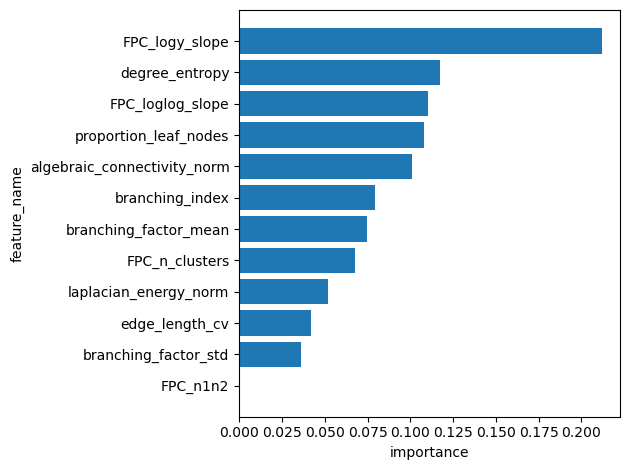

Classification Accuracy: 0.94


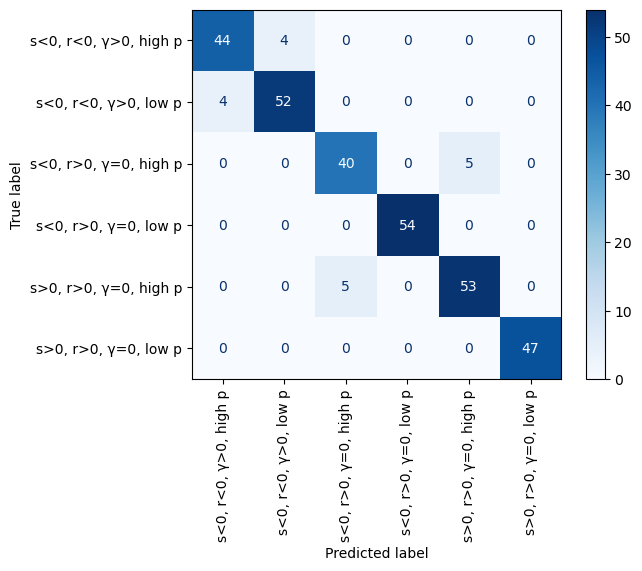

In [12]:
# import random
# random.shuffle(feature_vecs)
feature_vecs = [np.array([feature_dict[k] for k in sorted(feature_dict.keys())]) for feature_dict in inflated_feature_dicts]
X_train, X_test, y_train, y_test = train_test_split(feature_vecs, inflated_labels, test_size=0.2)

model = RandomForestClassifier(n_estimators=100)
model.fit(X_train, y_train)
y_pred = model.predict(X_test)

feature_name, importance = zip(*reversed(sorted(zip(inflated_feature_dicts[0].keys(), model.feature_importances_), key=lambda x: x[1], reverse=True)))
plt.barh(feature_name, importance)
plt.xlabel("importance")
plt.ylabel("feature_name")
plt.tight_layout()
plt.show()
# print(model.classes_)
accuracy = accuracy_score(y_test, y_pred)
print(f"Classification Accuracy: {accuracy:.2f}")
cm = confusion_matrix(y_test, y_pred, labels=model.classes_)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=model.classes_)
disp.plot(cmap='Blues', xticks_rotation=90)
plt.show()

In [13]:
joblib.dump(model, './data/rf_model.pkl')
loaded_model = joblib.load('./data/rf_model.pkl')

In [14]:
def extract_local_PCs(population): 
    
    global_state_vecs = np.array([cell.state_vec for cell in population])
    
    n_rounds = 10
    knn = NearestNeighbors(n_neighbors = 1000, algorithm='auto')
    knn.fit(global_state_vecs)
    multiple_local_PCs = []
    for _ in range(n_rounds):
        random_idx = np.random.choice(range(len(global_state_vecs)))
        random_point = global_state_vecs[random_idx]
        _, indices = knn.kneighbors([random_point])
        local_state_vecs = StandardScaler().fit_transform(np.array([global_state_vecs[index] for index in indices[0]]))
        local_PCs = PCA(n_components=20).fit_transform(local_state_vecs)
        multiple_local_PCs.append(local_PCs)
    return multiple_local_PCs

nested_local_PCs = Parallel(n_jobs=os.cpu_count())(
    delayed(extract_local_PCs)(population) for population in populations
)

In [15]:
all_local_PCs = np.array([item for sublist in nested_local_PCs for item in sublist])
inflated_labels = [x for item in labels for x in [item] * 10]
print(all_local_PCs.shape)
print(len(inflated_labels))
# print(len(all_local_PCs[0][0]), len(labels))

(1540, 1000, 20)
1540


In [ ]:
import torch
import torch.nn.functional as F
from sklearn.model_selection import train_test_split
from scipy.sparse.csgraph import minimum_spanning_tree
from scipy.spatial.distance import pdist, squareform
from torch_geometric.data import Data
from torch_geometric.nn import GCNConv
from sklearn.preprocessing import LabelEncoder
from torch_geometric.nn import global_mean_pool


# Encode string labels to integers
label_encoder = LabelEncoder()
label_encoder.fit(labels)
encoded_labels = label_encoder.transform(inflated_labels)

print(all_local_PCs.shape, encoded_labels.shape)
# Collect features and labels
graph_data_list = []

for pcs, label in zip(all_local_PCs, encoded_labels):
    dist_matrix = squareform(pdist(pcs))
    mst_sparse = minimum_spanning_tree(dist_matrix)
    mst_coo = mst_sparse.tocoo()

    edge_index = np.vstack((mst_coo.row, mst_coo.col))
    edge_index = np.hstack((edge_index, edge_index[::-1, :]))  # make graph undirected
    edge_index = torch.tensor(edge_index, dtype=torch.long)

    x = torch.tensor(pcs, dtype=torch.float)
    y = torch.tensor(label, dtype=torch.long)  # one label per graph

    graph = Data(x=x, edge_index=edge_index, y=y)
    graph_data_list.append(graph)

# Combine graphs into one large batch graph (optional if you're using batch-wise training)
from torch_geometric.loader import DataLoader
if len(graph_data_list) > 1:
    train_graphs, test_graphs = train_test_split(graph_data_list, test_size=0.2, random_state=42)
else:
    train_graphs = test_graphs = graph_data_list

dataloader = DataLoader(train_graphs, batch_size=4, shuffle=True)
testloader = DataLoader(test_graphs, batch_size=4)


In [22]:
import matplotlib.pyplot as plt

class MST_GCN(torch.nn.Module):
    def __init__(self, input_dim, hidden_dim, num_classes):
        super(MST_GCN, self).__init__()
        self.conv1 = GCNConv(input_dim, hidden_dim)
        self.conv2 = GCNConv(hidden_dim, hidden_dim)

        self.mlp = torch.nn.Sequential(
            torch.nn.Linear(hidden_dim, hidden_dim * 2),
            torch.nn.ReLU(),
            torch.nn.Dropout(0.1),
            torch.nn.Linear(hidden_dim * 2, hidden_dim),
            torch.nn.ReLU(),
            torch.nn.Dropout(0.1),
            torch.nn.Linear(hidden_dim, num_classes)
        )

    def forward(self, x, edge_index, batch):
        x = F.relu(self.conv1(x, edge_index))
        x = F.relu(self.conv2(x, edge_index))
        x = global_mean_pool(x, batch)  # Pool over each graph
        return self.mlp(x)

model = MST_GCN(input_dim=20, hidden_dim=64, num_classes=len(label_encoder.classes_))
optimizer = torch.optim.Adam(model.parameters(), lr=0.01, weight_decay=5e-4)
criterion = torch.nn.CrossEntropyLoss()

train_losses = []
test_losses = []
test_accuracies = []

# Train model
for epoch in range(100):
    model.train()
    total_loss = 0
    for batch in dataloader:
        optimizer.zero_grad()
        out = model(batch.x, batch.edge_index, batch.batch)
        loss = criterion(out, batch.y)
        loss.backward()
        optimizer.step()
        total_loss += loss.item()

    train_losses.append(total_loss)

    # Evaluate model
    model.eval()
    correct = 0
    total = 0
    test_loss = 0
    with torch.no_grad():
        for batch in testloader:
            out = model(batch.x, batch.edge_index, batch.batch)
            loss = criterion(out, batch.y)
            test_loss += loss.item()
            pred = out.argmax(dim=1)
            correct += (pred == batch.y).sum().item()
            total += batch.y.size(0)

    accuracy = correct / total
    test_losses.append(test_loss)
    test_accuracies.append(accuracy)

    if epoch % 1 == 0:
        print(f"Epoch {epoch}, Loss: {total_loss:.4f}, Test Loss: {test_loss:.4f}, Test Accuracy: {accuracy:.2%}")

# Final evaluation
model.eval()
correct = 0
total = 0
with torch.no_grad():
    for batch in testloader:
        out = model(batch.x, batch.edge_index, batch.batch)
        pred = out.argmax(dim=1)
        correct += (pred == batch.y).sum().item()
        total += batch.y.size(0)

print(f"Final Test Accuracy: {correct / total:.2%}")

Epoch 0, Loss: 430.4532, Test Loss: 90.1704, Test Accuracy: 32.47%
Epoch 1, Loss: 373.4738, Test Loss: 88.4306, Test Accuracy: 43.18%
Epoch 2, Loss: 365.2347, Test Loss: 96.4780, Test Accuracy: 29.22%
Epoch 3, Loss: 371.1809, Test Loss: 87.9347, Test Accuracy: 39.29%
Epoch 4, Loss: 367.8734, Test Loss: 90.2333, Test Accuracy: 32.14%
Epoch 5, Loss: 365.9167, Test Loss: 91.8409, Test Accuracy: 28.57%
Epoch 6, Loss: 372.6951, Test Loss: 87.8809, Test Accuracy: 34.09%
Epoch 7, Loss: 364.0525, Test Loss: 88.1328, Test Accuracy: 37.99%
Epoch 8, Loss: 361.4134, Test Loss: 91.3695, Test Accuracy: 29.87%
Epoch 9, Loss: 361.9699, Test Loss: 92.4562, Test Accuracy: 32.14%
Epoch 10, Loss: 359.1309, Test Loss: 88.4591, Test Accuracy: 38.31%
Epoch 11, Loss: 361.2538, Test Loss: 93.1988, Test Accuracy: 29.55%
Epoch 12, Loss: 349.7932, Test Loss: 90.4178, Test Accuracy: 37.66%
Epoch 13, Loss: 348.8287, Test Loss: 82.0390, Test Accuracy: 42.21%
Epoch 14, Loss: 345.5141, Test Loss: 84.3514, Test Accurac

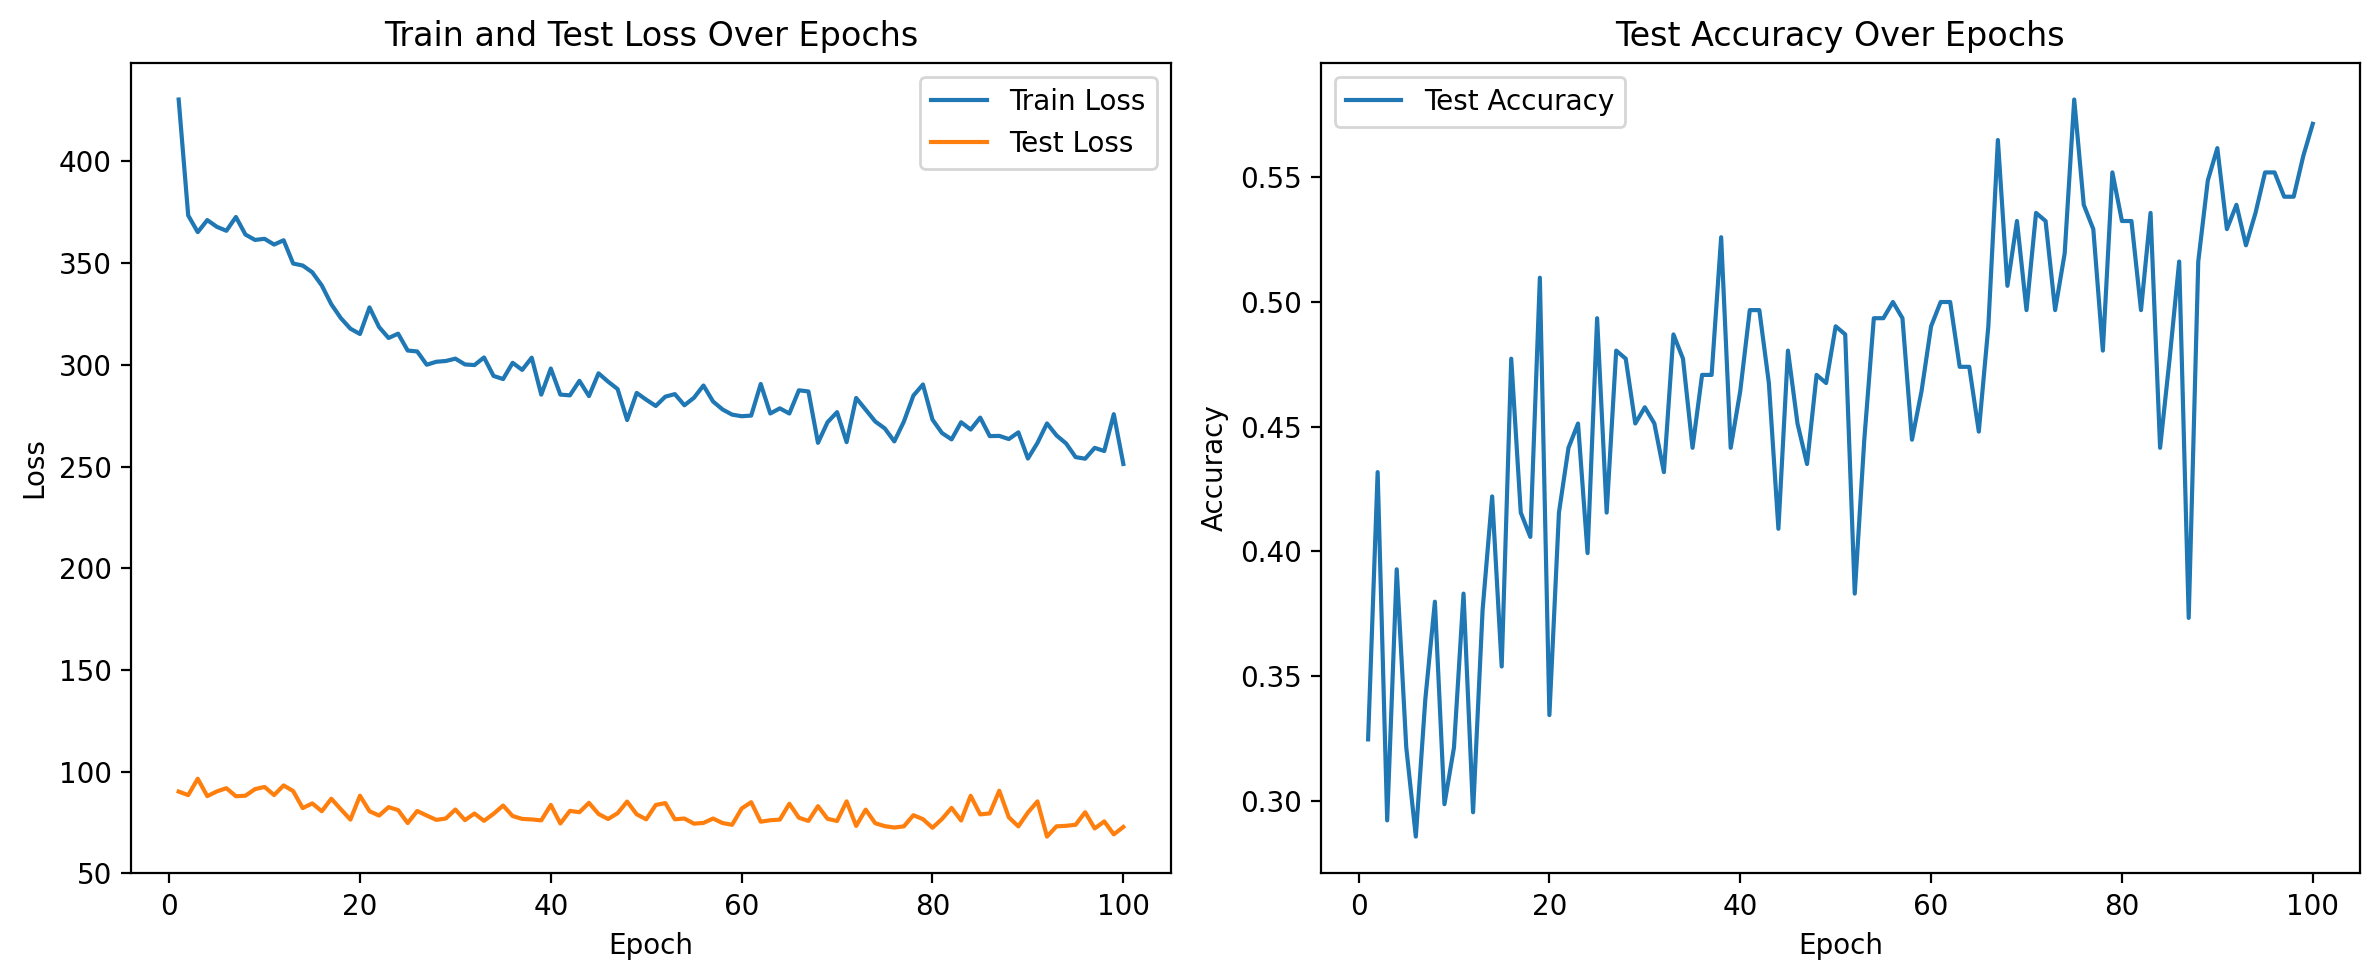

In [23]:
# Plotting training & test loss and test accuracy
epochs = range(1, 101)
plt.figure(figsize=(12, 5), dpi=200)

plt.subplot(1, 2, 1)
plt.plot(epochs, train_losses, label='Train Loss')
plt.plot(epochs, test_losses, label='Test Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Train and Test Loss Over Epochs')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(epochs, test_accuracies, label='Test Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Test Accuracy Over Epochs')
plt.legend()

plt.tight_layout()
plt.show()
